In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import shap
import xgboost as xgb
import seaborn as sns
from catboost import CatBoostRegressor

In [44]:
df=pd.read_csv(r"C:\Users\racha\Downloads\6399ff5a24dba_TECHTONIC_SHIFT_ROUND_2\Historical.csv")

In [45]:
df.columns

Index(['Row Id', 'Front_Length', 'Area', 'Street_Type', 'Area_Shape',
       'Flatness', 'Prop_Config', 'Neighborhood', 'Building_Type',
       'Building_Style', 'Quality_Rating', 'Condition_Rating',
       'Year_Constructed', 'Year_Remodelled', 'RoofStyle', 'Roof_Material',
       'Exterior_Material', 'Exterior_Quality', 'Veneer_Type', 'Veneer_Area',
       'Foundation_Type', 'Basement_Quality', 'Basement_Finish',
       'Basement_Finish_Area', 'Total_Basement_Area', 'Heating_Type',
       'Heating_Quality', 'AirConditioning', 'Electrical', '1stFloor_Area',
       '2ndFloor_Area', 'Low_Quality_Area', 'FullBath_Count', 'HalfBath_Count',
       'Bedroom_Count', 'Kitchen_Count', 'Kitchen_Quality',
       'Functionality_Rating', 'Fireplace_Count', 'Fireplace_Quality',
       'GarageType', 'Garage_Constructed_Year', 'GarageFinish',
       'Garage_Car_Capacity', 'GarageArea', 'Garage_Quality', 'Wood_Deck_Area',
       'Open_Porch_Area', 'Enclosed_Porch_Area', 'Three_Season_Porch_Area',
    

In [46]:
cat_list=[]
for i in range(len(df.dtypes)):
    if df.dtypes[i] == 'object':
        cat_list.append(df.columns[i])


In [47]:
cat_list
ordinal_cat_list=['Exterior_Quality','Basement_Quality','Basement_Finish','Heating_Quality','Kitchen_Quality','Fireplace_Quality','GarageFinish','Garage_Quality']
cat_list=[i for i in cat_list if i not in ordinal_cat_list]
quality_dict={'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
basement_finish_types={'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
garage_finish_type={'Fin':3,'RFn':2,'Unf':1}


In [48]:
important_num_cols = list(df.corr()["SalePrice"][(df.corr()["SalePrice"]>0.50) | (df.corr()["SalePrice"]<-0.50)].index)
df=df.replace(np.nan, 0)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [49]:
cat_list
to_drop=['Street_Type','Roof_Material',]

In [50]:
df.nunique(axis=0)

Row Id                     1138
Front_Length                105
Area                        868
Street_Type                   2
Area_Shape                    4
Flatness                      4
Prop_Config                   5
Neighborhood                 25
Building_Type                 5
Building_Style                8
Quality_Rating               10
Condition_Rating              9
Year_Constructed            110
Year_Remodelled              61
RoofStyle                     6
Roof_Material                 8
Exterior_Material            15
Exterior_Quality              5
Veneer_Type                   5
Veneer_Area                 280
Foundation_Type               6
Basement_Quality              5
Basement_Finish               7
Basement_Finish_Area        552
Total_Basement_Area         624
Heating_Type                  6
Heating_Quality               5
AirConditioning               2
Electrical                    6
1stFloor_Area               662
2ndFloor_Area               356
Low_Qual

In [51]:
df_enc=pd.get_dummies(df, drop_first = True, columns = cat_list ) #encoding nominal variables
# encoder = OrdinalEncoder()

In [52]:
#encoding ordinal variables 
for k in ordinal_cat_list:
    if k=='GarageFinish':
        for i in range(df_enc.shape[0]):
            try:
                df_enc['GarageFinish'][i]=garage_finish_type[df_enc['GarageFinish'][i]]
            except:
                df_enc['GarageFinish'][i]=0
    elif k=='Basement_Finish':
        for d in range(df_enc.shape[0]):
            # count+=1
            # print(df_enc['Basement_Finish'][d],count)
            try:
                df_enc['Basement_Finish'][d]=basement_finish_types[df_enc['Basement_Finish'][d]]
            except:
                df_enc['Basement_Finish'][d]=0
    else:
        for i in range(df_enc.shape[0]):
            try:
                df_enc[k][i]=quality_dict[df_enc[k][i]]
            except:
                df_enc[k][i]=0
    df_enc[k]=pd.to_numeric(df_enc[k])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [53]:
important_num_cols.remove("SalePrice")
important_num_cols

['Quality_Rating',
 'Year_Constructed',
 'Year_Remodelled',
 'Total_Basement_Area',
 '1stFloor_Area',
 'FullBath_Count',
 'Garage_Car_Capacity',
 'GarageArea']

In [54]:
y=df_enc['SalePrice']
X=df_enc.drop(['SalePrice','Row Id'],axis=1)

In [55]:
scaler = StandardScaler()
X[important_num_cols] = scaler.fit_transform(X[important_num_cols])

In [56]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,random_state=104,test_size=0.20, shuffle=True)

In [57]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse
    

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared

In [58]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])

In [59]:
regressor = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot: >

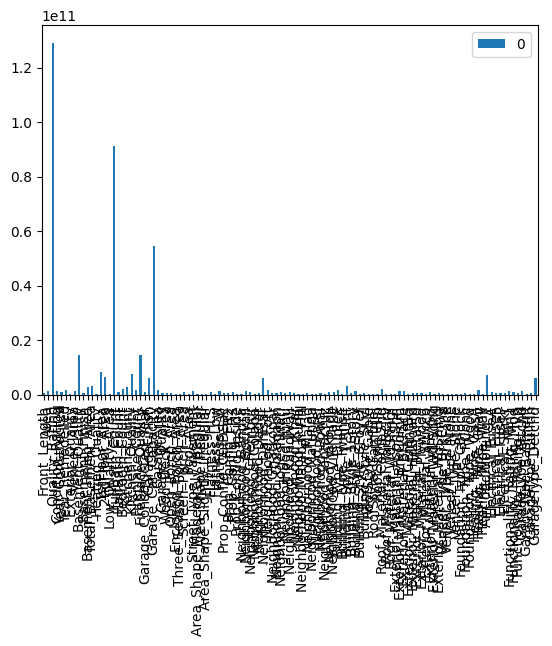

In [60]:
feat_importance=regressor.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame.from_dict(data=feat_importance,orient='index')
importance_df.plot.bar()

In [61]:
# feat_importance
feat_importance={k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1])}

In [62]:
feat_importance

{'Heating_Type_Wall': 53213484.0,
 'RoofStyle_Hip': 67993208.0,
 'Pool_Area': 104977368.0,
 'Area_Shape_Moderately Irregular': 119505560.0,
 'Neighborhood_Colaba': 121514792.0,
 'Roof_Material_WdShngl': 122189376.0,
 'RoofStyle_Gable': 141470384.0,
 'Veneer_Type_None': 141710992.0,
 'Heating_Type_GasA': 153205904.0,
 'Neighborhood_Malabar Hill': 175566176.0,
 'Building_Style_SFoyer': 191183616.0,
 'Three_Season_Porch_Area': 201691968.0,
 'Low_Quality_Area': 210182864.0,
 'Foundation_Type_Wood': 219152384.0,
 'Area_Shape_Regular': 225346112.0,
 'Neighborhood_Matunga': 226030320.0,
 'Neighborhood_Kurla': 228248688.0,
 'Roof_Material_Tar&Grv': 239992832.0,
 'Exterior_Material_Stucco': 240424976.0,
 'Prop_Config_Inside': 243727616.0,
 'Veneer_Type_Stone': 251074992.0,
 'Heating_Quality': 258450928.0,
 'Exterior_Quality': 261671472.0,
 'Veneer_Type_BrkCmn': 270083680.0,
 'Flatness_Low': 284217920.0,
 'Area_Shape_Slightly Irregular': 286355104.0,
 'Foundation_Type_CBlock': 289383968.0,
 'Nei

In [63]:
y_pred = regressor.predict(X_test)

In [64]:
mae, mse, rmse, r_squared = evaluation(y_test, y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(regressor)
print("RMSE Cross-Validation:", rmse_cross_val)

MAE: 16005.68475877193
MSE: 758871563.1277659
RMSE: 27547.623547735762
R2 Score: 0.8680826067836622
------------------------------
RMSE Cross-Validation: 26615.52311623151


In [65]:
new_row = {"Model": "XGBRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)
    

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [66]:
svr = SVR(C=100000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(svr)
print("RMSE Cross-Validation:", rmse_cross_val)
new_row = {"Model": "SVR","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 40272.4359426668
MSE: 3792726688.461357
RMSE: 61585.11742670754
R2 Score: 0.34069657866515846
------------------------------
RMSE Cross-Validation: 62435.17209246949


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [67]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(lin_reg)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "LinearRegression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 23414.181922904012
MSE: 3149091123.138635
RMSE: 56116.76329884534
R2 Score: 0.4525820808820892
------------------------------
RMSE Cross-Validation: 42972.31912584758


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [68]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
predictions = elastic_net.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(elastic_net)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "ElasticNet","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 21213.603405638252
MSE: 1026957300.9254555
RMSE: 32046.174513121772
R2 Score: 0.821480291705484
------------------------------
RMSE Cross-Validation: 35851.468042200664


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [69]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(lasso)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Lasso","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.296e+11, tolerance: 5.756e+08
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+11, tolerance: 5.870e+08


MAE: 23290.188599751087
MSE: 3053168708.567973
RMSE: 55255.48577804717
R2 Score: 0.4692566217345946
------------------------------


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.446e+11, tolerance: 5.695e+08
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e+11, tolerance: 5.265e+08
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e+11, tolerance: 6.009e+08


RMSE Cross-Validation: 42451.08869445601


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+11, tolerance: 5.446e+08
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [70]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(ridge)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Ridge","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 22055.69980345187
MSE: 978812888.1551023
RMSE: 31285.985491192416
R2 Score: 0.8298494094049531
------------------------------
RMSE Cross-Validation: 33383.295336661155


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [71]:
X_tr1, X_te1,y_tr1, y_te1 = train_test_split(X_train,y_train,random_state=104,test_size=0.1, shuffle=True)
cat_model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
cat_model.fit(X_tr1, y_tr1,eval_set=(X_te1, y_te1),plot=True)
predictions=cat_model.predict(X_test)
mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(ridge)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "CAT Boost","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76213.0821387	test: 63763.5501169	best: 63763.5501169 (0)	total: 1.46ms	remaining: 71.3ms
1:	learn: 71938.2323029	test: 59633.0783862	best: 59633.0783862 (1)	total: 2.7ms	remaining: 64.7ms
2:	learn: 68369.8533771	test: 56158.6222325	best: 56158.6222325 (2)	total: 3.62ms	remaining: 56.7ms
3:	learn: 64952.1901359	test: 52871.5409887	best: 52871.5409887 (3)	total: 4.44ms	remaining: 51.1ms
4:	learn: 62026.1615660	test: 50315.3408418	best: 50315.3408418 (4)	total: 5.18ms	remaining: 46.6ms
5:	learn: 59468.1047234	test: 47943.7812331	best: 47943.7812331 (5)	total: 6.23ms	remaining: 45.7ms
6:	learn: 56856.4416615	test: 45404.8022108	best: 45404.8022108 (6)	total: 6.99ms	remaining: 43ms
7:	learn: 54689.5310427	test: 43137.2002980	best: 43137.2002980 (7)	total: 7.8ms	remaining: 41ms
8:	learn: 52644.8225757	test: 41195.7438902	best: 41195.7438902 (8)	total: 8.61ms	remaining: 39.2ms
9:	learn: 50956.3980016	test: 39697.5962335	best: 39697.5962335 (9)	total: 9.42ms	remaining: 37.7ms
10:	le

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


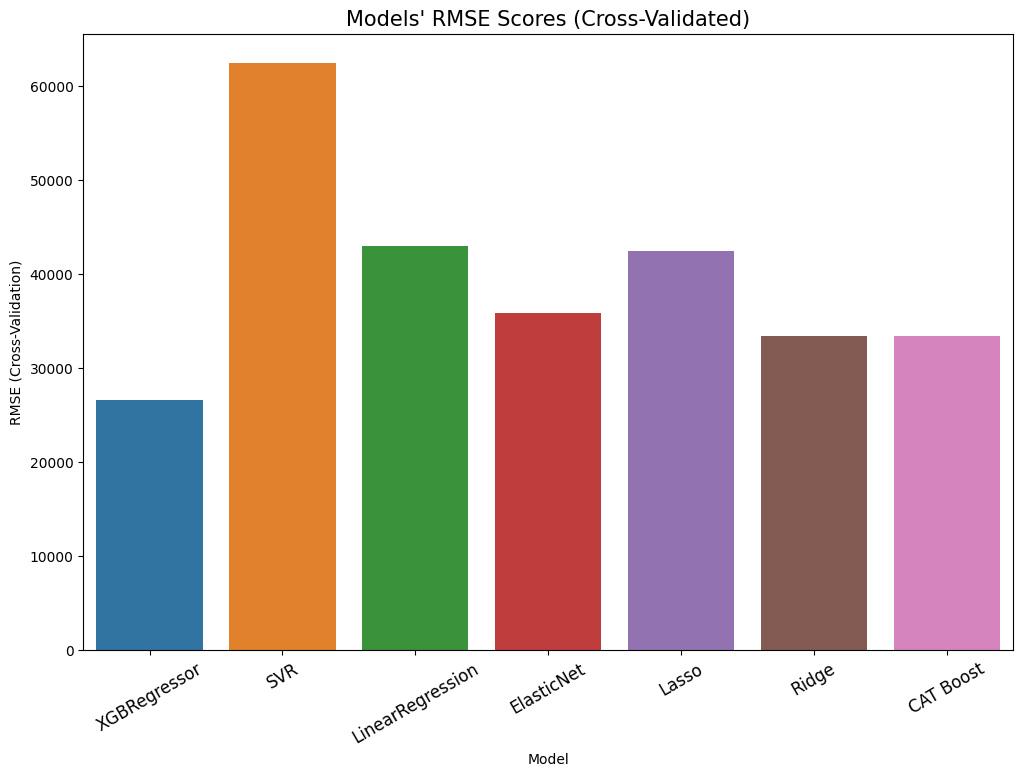

In [72]:
plt.figure(figsize=(12,8))
sns.barplot(x=models["Model"], y=models["RMSE (Cross-Validation)"])
plt.title("Models' RMSE Scores (Cross-Validated)", size=15)
plt.xticks(rotation=30, size=12)
plt.show()

In [73]:
models.sort_values(by="RMSE (Cross-Validation)")

,Model,MAE,MSE,RMSE,R2 Score,RMSE (Cross-Validation)
0,XGBRegressor,16005.684759,7.588716e+08,27547.623548,0.868083,26615.523116
5,Ridge,22055.699803,9.788129e+08,31285.985491,0.829849,33383.295337
6,CAT Boost,18251.262491,8.238166e+08,28702.205980,0.856793,33383.295337
3,ElasticNet,21213.603406,1.026957e+09,32046.174513,0.821480,35851.468042
4,Lasso,23290.188600,3.053169e+09,55255.485778,0.469257,42451.088694
2,LinearRegression,23414.181923,3.149091e+09,56116.763299,0.452582,42972.319126
1,SVR,40272.435943,3.792727e+09,61585.117427,0.340697,62435.172092


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


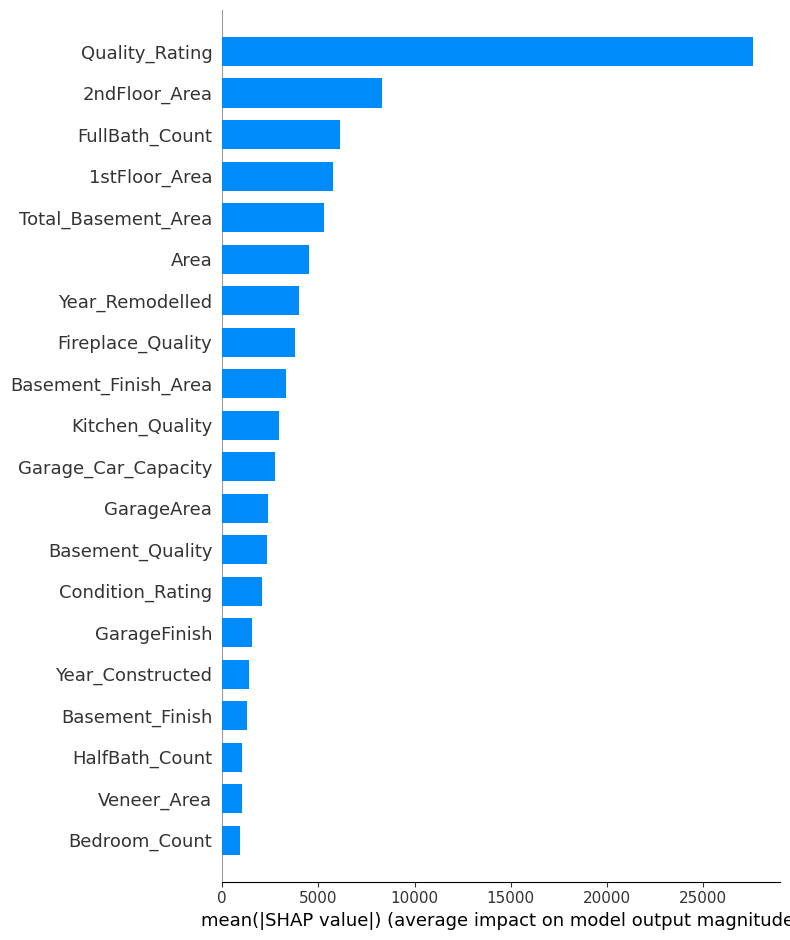

In [74]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_importance)
shap.summary_plot(shap_values, X_importance, plot_type='bar')